# 1

In [140]:
import scipy.io as scipy_io
from scipy import sparse 
import numpy as np
import quadprog
import math
import cvxopt
import matplotlib.pyplot as plt

from cvxopt import matrix, solvers 
from sklearn.svm import SVC

In [141]:
mat = scipy_io.loadmat('cbcl1.mat')

In [142]:
    
def softsvm(X, l, gamma):
    D,N = X.shape

    x = np.repeat(1, N + D + 1) #should it be 1? i honestly dont know
    G = np.identity(n=N+D+1) * np.concatenate((np.repeat(0.00001, N), np.repeat(1, D), np.repeat(0.00001,1)), axis = 0)
    
    P = np.identity(n=N+D+1) * np.concatenate((np.repeat(0, N), np.repeat(1, D), np.repeat(0,1)), axis = 0)
    q = np.concatenate((np.repeat(gamma, N), np.repeat(0, D + 1)))
    
    I_n = -1*np.identity(N)
    LdotX = -1*np.dot(np.identity(N) * l, np.transpose(X))
    lil_l = -1*l
    
    #now create the bottom part of "G", the infinity section
    
    G_bottom = -1*np.identity(n=N+D+1)
    G = np.concatenate((I_n, np.transpose(LdotX), np.transpose(lil_l)))
    #G =np.concatenate((-1*np.identity(N), np.transpose(np.dot(np.identity(N) * l, np.transpose(X))), np.transpose(-1*l)))
    G= np.transpose(G)
    
    Gstack = np.concatenate((G, G_bottom))
    h = np.concatenate((np.repeat(-1, G.shape[0]), np.zeros(N,), 100000*np.ones(D+1)))
     
    A = np.identity(n = N + D + 1)
    b= np.repeat(1, N + D +1)
    
    P = matrix(P.astype('float'))
    q = matrix(q.astype('float'))
    Gstack = matrix(Gstack.astype('float'))
    h = matrix(h.astype('float'))
    A = matrix(A.astype('float'))
    b = matrix(b.astype('float'))

    sol = cvxopt.solvers.qp(P,q,Gstack, h)
    #http://cvxopt.org/userguide/coneprog.html#quadratic-programming
    #quadprog.solve_qp()
        #min 1/2 (x.T P X + q.T x)
        #st G x <= h
        #st A x =  b
    
    #sol = quadprog.solve_qp(G, a, c, b, meq)

# distribute components of x into w, b, and xi:

    xi = np.array(sol['x'][0:(N)])
    w = np.array(sol['x'][N:(N + D)])
    b = np.array(sol['x'][N + D])
    
    return(w, b, xi)




# 2

In [143]:
X = mat["X"]
l = mat["L"]
dims = mat["dims"]
temp = softsvm(X, l, 0.005)

w = temp[0]
b = temp[1]
xi = temp[2]

     pcost       dcost       gap    pres   dres
 0:  1.8727e+05 -8.4110e+09  4e+11  2e-02  1e+09
 1:  1.9626e+05 -4.2141e+09  4e+09  2e-04  1e+07
 2:  1.4407e+05 -1.0366e+08  1e+08  5e-06  3e+05
 3:  4.0404e+04 -8.0265e+06  8e+06  4e-07  2e+04
 4:  1.6922e+04 -1.6638e+06  2e+06  6e-08  4e+03
 5:  1.2669e+04 -2.0606e+05  2e+05  8e-09  5e+02
 6:  1.1209e+04 -9.8884e+03  2e+04  4e-10  2e+01
 7:  2.1797e+03 -1.3819e+02  2e+03  8e-13  6e-02
 8:  5.3370e+02 -4.0381e+01  6e+02  1e-13  9e-03
 9:  3.8516e+02 -2.5981e+01  4e+02  7e-14  5e-03
10:  8.0327e+01 -4.6118e+00  8e+01  1e-14  9e-04
11:  3.5905e+01  2.0033e+00  3e+01  4e-15  2e-04
12:  1.8969e+01  4.8980e+00  1e+01  1e-15  8e-05
13:  1.5663e+01  5.8390e+00  1e+01  7e-16  5e-05
14:  1.2604e+01  6.7196e+00  6e+00  4e-16  3e-05
15:  1.1518e+01  7.1137e+00  4e+00  3e-16  2e-05
16:  1.0206e+01  7.6109e+00  3e+00  2e-16  9e-06
17:  9.5774e+00  7.8854e+00  2e+00  2e-16  5e-06
18:  9.1323e+00  8.0907e+00  1e+00  2e-16  3e-06
19:  8.9003e+00  8.20

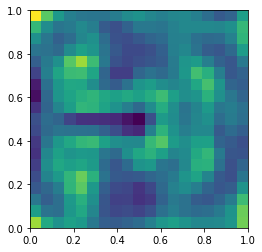

In [144]:
dat_2 = np.reshape(w, [dims[0][0], dims[0][1]])
plt.imshow(dat_2, extent=[0, 1, 0, 1])

This image appears very similar to the "mean face" of a couple labs ago. This makes sense, as w is the image of maximal distance from the two classes of images. Since one class is just random images, then w should be mostly defined by the features of the face class - as we can see in this image. 

# 3

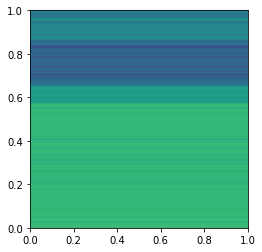

In [146]:
dat_3 = np.dot(np.transpose(X), w) + b
plt.imshow(dat_3, extent=[0, 1, 0, 1])

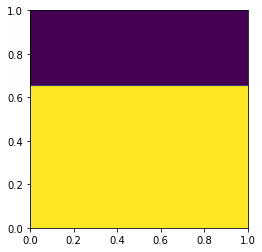

In [148]:
plt.imshow(l, extent=[0, 1, 0, 1])

Here we see that the svm performs very well at classifying images - there is a clearn boundary in predicted values when there image class changes. Some missclassifications are apparent however, as some points are plotted green in the blue section of the first plot, and vice versa. 

# 4

Text(0, 0.5, 'Slack Variable')

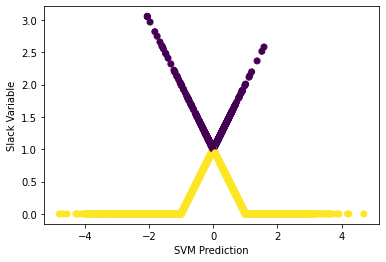

In [149]:
pred = np.dot(np.transpose(X), w) + b
np.sign(l) == np.sign(pred)
xi.shape
pred.shape
plt.scatter(y = xi, x = pred, c = np.sign(l) == np.sign(pred))
plt.xlabel("SVM Prediction")
plt.ylabel("Slack Variable")


 In the above plot, the slack variables for the correct predictions, in yellow, are 0 until the predictions start to approach 0. Once they meet and start moving away from 0 again the color changes to purple, these predictions were not correct. 

# 5

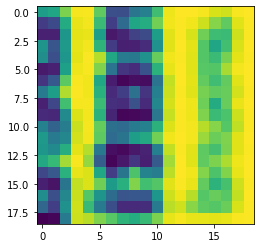

In [150]:
max_image = np.transpose(X)[np.argmax(dat_3), ]


fig = plt.imshow(np.reshape(max_image, [dims[0][0], dims[0][1]]))

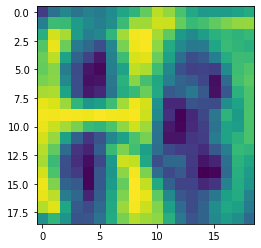

In [151]:
min_image = np.transpose(X)[np.argmin(dat_3), ]
fig = plt.imshow(np.reshape(min_image, [dims[0][0], dims[0][1]]))

I would expect these to be images of the random image most unlike a face, and a face most dissamilar to a "random image". The random image appears to be nearly opposite to a face (with a dark swatch exactly between where the brow and the mouth of the face would be expected). The face appears fairly similar to "mean face", and has distinct features. 

# 6

In [152]:
news = scipy_io.loadmat('news.mat')

X = news["X"]
l = news["L"]
words = news["dict"]

temp = softsvm(X, l, 0.005)

w = temp[0]
b = temp[1]
xi = temp[2]

     pcost       dcost       gap    pres   dres
 0:  8.8305e+12 -6.7989e+13  2e+14  7e-01  1e+09
 1:  3.3262e+10 -3.1667e+13  3e+13  1e-01  2e+08
 2:  7.2443e+10 -2.0450e+13  2e+13  4e-02  9e+07
 3:  4.1516e+09 -2.5286e+12  3e+12  4e-03  8e+06
 4:  1.8980e+07 -1.1753e+11  1e+11  2e-04  3e+05
 5:  8.6001e+05 -2.7966e+09  3e+09  4e-06  8e+03
 6:  8.3668e+05 -3.1792e+07  3e+07  5e-08  9e+01
 7:  5.8065e+05 -3.1651e+05  9e+05  5e-10  9e-01
 8:  2.7516e+04 -1.3187e+04  4e+04  2e-11  4e-02
 9:  2.9355e+03 -1.7227e+03  5e+03  2e-12  4e-03
10:  8.5530e+02 -6.6738e+02  2e+03  6e-13  1e-03
11:  3.6859e+02 -3.6172e+02  7e+02  3e-13  5e-04
12:  9.9185e+01 -1.4209e+02  2e+02  6e-14  1e-04
13:  1.7287e+01 -3.3930e+01  5e+01  7e-15  1e-05
14:  4.2898e+00 -7.5230e+00  1e+01  9e-16  2e-06
15:  1.9535e+00 -2.3169e+00  4e+00  3e-16  4e-07
16:  1.4505e+00 -9.1988e-01  2e+00  2e-16  2e-07
17:  1.1258e+00  1.5351e-01  1e+00  2e-16  5e-08
18:  9.8759e-01  6.8354e-01  3e-01  2e-16  7e-09
19:  9.4436e-01  8.72

In [153]:
max_locs = np.argpartition(w.reshape(1, w.size), -5)[0][-5:]
max_word = np.transpose(words)[max_locs, ]

In [154]:
min_locs = np.argpartition(w.reshape(1, w.size), -5)[0][:5]
min_word = np.transpose(words)[min_locs, ]

In [155]:
max_word

array(['science                                                                        ',
       'orbit                                                                          ',
       'pat                                                                            ',
       'space                                                                          ',
       'moon                                                                           '],
      dtype='<U79')

Based on the weights, science, orbit, pat, space, and moon are all heavily weighted. This suggests these words are those that best seperate our two classes.

Are lowest weighted words have nothing to do with space, there is not an obvious pattern which is reassuring.

In [163]:
min_word

array(['900                                                                            ',
       'enigma                                                                         ',
       'mvanheyn                                                                       ',
       'cs                                                                             ',
       'indiana                                                                        '],
      dtype='<U79')

Next, to see what was associated with the word 'space' we tried taking the inner product of space with the rest of the dataset. 56 of the words had a norm of 0, so we added a small number to be able to divide each vector by its norm without getting a divide by 0 error.  We got the following words, after normalizing the matrix

In [157]:
Xnorm = X / (0.00001 + np.linalg.norm(X, axis=1)[:,None]) #get read of 0 norm vectors
cov = (np.dot(X[1544,:]/np.linalg.norm(X[1544,:]), np.transpose(Xnorm)))

#plt.hist(cov)
#max_locs = np.argpartition(cov.reshape(1, cov.size), -5)[0][:5]
#max_word = np.transpose(words)[max_locs, ]

#print(max_locs)
#print(max_word)

In [158]:
max_locs = np.argpartition(cov.reshape(1, cov.size), -5)[0][-5:]
max_word = np.transpose(words)[max_locs, ]

print(max_locs)
print(max_word)

[3304 1544 7089 5367 8390]
['march                                                                          '
 'space                                                                          '
 'satellite                                                                      '
 'satellites                                                                     '
 '1995                                                                           ']


To me, logically, the words most related to space are those with the normalized inner product closest to 1. The question isn't necessarily about which ones best seperate the two classes. Now, I would think, if two words are co-linear they would be weighted similarly. If I expand the words out maybe I will see words with similarly high weights, as seen several lines up. 

In [159]:
max_locs = np.argpartition(cov.reshape(1, cov.size), -5)[0][-20:]
max_word = np.transpose(words)[max_locs, ]

print(max_locs)
print(max_word)

[9434 8165 8797 5076 9430 7974 3408 9431 8123 9433 4858  440 8173 9429
 7829 3304 1544 7089 5367 8390]
['mlv                                                                            '
 'projections                                                                    '
 'condor                                                                         '
 'sales                                                                          '
 'capricornia                                                                    '
 'launch                                                                         '
 'venture                                                                        '
 'pacastro                                                                       '
 'positioning                                                                    '
 'iridium                                                                        '
 'contrast                                                         

Below, we looked at the words with the smallest inner product. There does not appear to be much pattern here. SARSAT has to do with space, so that is concerning. 

In [160]:
max_locs = np.argpartition(cov.reshape(1, cov.size), -5)[0][:5]
max_word = np.transpose(words)[max_locs, ]

print(max_locs)
print(max_word)

#print(np.dot(X[1544,:]/np.linalg.norm(X[1544,:]), np.transpose(X[1544,:]/np.linalg.norm(X[1544,:]))))
#print(np.dot(X[1544,:]/np.linalg.norm(X[1544,:]), np.transpose(X[9616,:]/np.linalg.norm(X[9616,:]))))


[1746 4827 9631 9617 9616]
['intentions                                                                     '
 'enigma                                                                         '
 'mccolm                                                                         '
 'unocal                                                                         '
 'sarsat                                                                         ']


EXTRA: I am assuming this question is more challenging than it appers. If newspaper was linear seperable, I would assume the graph below would be completely yellow (all correct) and there would be a gap in the dots around 0. The fact that there are predictions close to 0, some of which are wrong, makes me think the data set is not linearly seperable. 

Text(0, 0.5, 'Slack Variable')

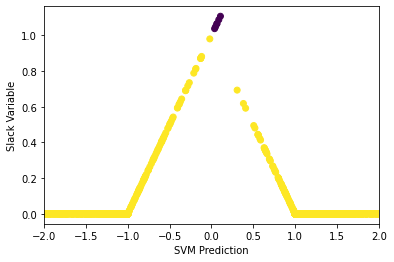

In [161]:
pred = np.dot(np.transpose(X), w) + b
np.sign(l) == np.sign(pred)
xi.shape
pred.shape
plt.scatter(y = xi, x = pred, c = np.sign(l) == np.sign(pred))
plt.xlim(-2,  2)
plt.xlabel("SVM Prediction")
plt.ylabel("Slack Variable")